<a href="https://colab.research.google.com/github/Segtanof/pyfin/blob/main/09_Scraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scraping

Often we want to download data from websites and other remote sources.



## HTTP basics
A few basics about web traffic are helpful to understand the process.

When you open a website, your browser (e.g. Firefox or Chrome) sends an HTTP request to the remote server (e.g. the SEC). The server sends back the requested webpage source code, which is then rendered by your browser and shown to you.

There are different types of HTTP requests. `GET` and `POST` are the most relevant for us. In particular `GET` requests are the ones we will see most often. These requests not only contain the link (URL) you type into your browser bar (or click on), but also `headers`.

Headers typically contain information about your computer, such as the browser you are using (e.g. Desktop or mobile versions), the languages you understand, etc. From this information, the remote server can for example show you a differently formatted website depending your (presumed) screen size (laptop vs smartphone).
Additionally cookies and other session related data are also transmitted. This way, you can for example prove to the server that you are logged in.

For example, when you type `sec.gov` into your browser, the following data is sent:

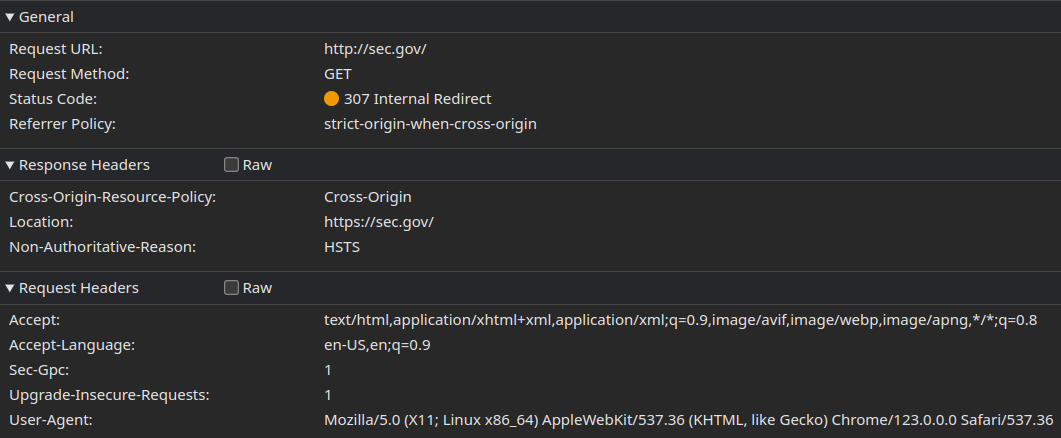

The other important thing to know about HTTP are status codes. We have all seen the `404 - not found` thing when we clicked on an outdated link or made a typo in the URL.
The `404` is the HTTP status code.

In general, the first digit denotes the group and the following two digits specify the status.

Groups `2xx`, `4xx`, and `5xx` are the most important for us.

The most important codes are:
- `200`: Success
- `4xx`: Something went wrong on our end
- `5xx`: Something went wrong on the server side

Now let's see this in practice.


We import a library called `requests` to send HTTP requests to websites.

In [1]:
!pip install pyfixest

In [15]:
# For data handling
import pandas as pd

# For downloading the data
import requests

# For rate-limiting the requests
import time

# For easy file management
from pathlib import Path

# For progress bars
from tqdm import tqdm

# For regressions
import pyfixest as pf

# For turning data into a file-like object that pandas can read
import io

# For parsing the HTML
from bs4 import BeautifulSoup

# For parsing JSON
import json

## Accessing an API

APIs are Application Programming Interfaces. This means that this is an endpoint that is made to be used by machines, not by humans. Thus, we don't want to open them in our browser, because it is not made to look good; it's made to transfer data from one machine to another, typically in a structured format.

APIs usually come with a documentation. This is the starting point for us.

Take a look at the [IMF's API documentation](https://www.imf.org/external/datamapper/api/help).

You can see that there are some examples at the bottom. How do they work? It looks like we have a base URL (`https://www.imf.org/external/datamapper/api/v1`), then the indicator we want to retrieve, and then a way to specify the time periods.

Thus, if we want to retrieve the real GDP growth for the U.S. from 2010 to 2011, we can build the query URL:
- First, the base url: `https://www.imf.org/external/datamapper/api/v1`
- Then, add the indicator (`NGDP_RPCH`), from the example, to get `https://www.imf.org/external/datamapper/api/v1/NGDP_RPCH`
- Then, add the country (`USA`): `https://www.imf.org/external/datamapper/api/v1/NGDP_RPCH/USA`
- Then, the periods (`?periods=2010,2011`).

Our final URL is: `https://www.imf.org/external/datamapper/api/v1/NGDP_RPCH/USA?periods=2010,2011`

Try to open it in your browser and see what we get!

**Quick exercise**
- Build the URL to retrieve the real GDP growth of the U.S. Virgin Islands for periods 2010 to 2012.
- Open the URL in your browser. Which "text" format is the result delivered in?
- Look at the request in your browser developer tools. Which type of request is it?

In [ ]:
https://www.imf.org/external/datamapper/api/v1/NGDP_RPCH/VIR/?periods=2020,2012

Let's now download that data with pandas.

In [3]:
pd.read_json("https://www.imf.org/external/datamapper/api/v1/NGDP_RPCH/USA?periods=2010,2011")

,values,api
NGDP_RPCH,"{'USA': {'2010': 2.7, '2011': 1.6}}",NaN
version,NaN,1
output-method,NaN,json


That's a good start, but we can see that it's not really in a good format. That is a very common issue. So we typically first have to clean up the data before turning it into a DataFrame. To do that, we first download the "raw" data using the `requests` package and a `GET` request.

In [2]:
url = "https://www.imf.org/external/datamapper/api/v1/NGDP_RPCH/USA?periods=2010,2011"
response = requests.get(url)

In [4]:
response # This should say 200, which means it's all good

<Response [200]>

In [5]:
# We can inspect the actual content of the response with `.text` or `.content`.
response.text

'{"values":{"NGDP_RPCH":{"USA":{"2010":2.70000000000000017763568394002504646778106689453125,"2011":1.600000000000000088817841970012523233890533447265625}}},"api":{"version":"1","output-method":"json"}}'

To turn this string into an actual dictionary, we have to "parse" it using the `json` package.

In [6]:
json.loads(response.text)
#        ^ the "s" is for load from "string"

{'values': {'NGDP_RPCH': {'USA': {'2010': 2.7, '2011': 1.6}}},
 'api': {'version': '1', 'output-method': 'json'}}

In [7]:
data1 = json.loads(response.text)

In [8]:
df = pd.json_normalize(data1['values']['NGDP_RPCH'])
df

,USA.2010,USA.2011
0,2.7,1.6


In [9]:
datadict = json.loads(response.text)
datadict

{'values': {'NGDP_RPCH': {'USA': {'2010': 2.7, '2011': 1.6}}},
 'api': {'version': '1', 'output-method': 'json'}}

Now we want to filter it to the relevant data. This means, we care only about the `values` key of the dictionary. Note that this is all specific to this API and can (probably will) be different for any other API.

In [10]:
datadict['values']

{'NGDP_RPCH': {'USA': {'2010': 2.7, '2011': 1.6}}}

In [15]:
datadict["values"].items()

dict_items([('NGDP_RPCH', {'USA': {'2010': 2.7, '2011': 1.6}})])

In [33]:
data = pd.DataFrame([
    {'country': country, 'year': year, indicator: value}
    for indicator, data in datadict['values'].items()
    for country, yearly_data in data.items()
    for year, value in yearly_data.items()
])
data

,country,year,NGDP_RPCH
0,USA,2010,2.7
1,USA,2011,1.6


Note that this is not the best / only / true approach. There are a lot of ways to achieve that. For example, there is also the `pd.json_normalize` function to mention one main alternative. Different API response formats would also make different approaches better / more appropriate.

Best practices:
- Ensure that your approach generalizes, i.e. allows you to process multiple countries / indicators / years at once.
- Keep it as short and readable as possible

In [54]:
usa_data = data1['values']['NGDP_RPCH']['USA']
df = pd.Series(usa_data).reset_index()
df.columns = ['Year', 'NGDP_RPCH']
df

,Year,NGDP_RPCH
0,2010,2.7
1,2011,1.6


In [45]:
data1['values']


{'NGDP_RPCH': {'USA': {'2010': 2.7, '2011': 1.6}}}

**Quick exercise**
- Use your AI tool of choice to go from the API response to the code that turns everything into a DataFrame.
- Make it a function that takes URL and outputs a DataFrame.
- Download data for the `GDP per capita, current prices\n` and the `Unemployment rate` for the U.S., the U.K., and Australia from 2010 to 2020.
- Run a regression to answer "What is the relationship between unemployment rate and GDP per capita, after controlling for permanent differences between countries and common time trends?".

In [16]:
def url_to_dataframe(url):
    """
    Fetch JSON data from a URL and convert to DataFrame
    
    Args:
        url (str): URL containing JSON data
    
    Returns:
        pd.DataFrame: Converted DataFrame from multiple columns
    """
    # Fetch data from URL
    response = requests.get(url)
    data = response.json()
    
    # Prepare flat data for multiple columns
    columns = ['NGDP_RPCH', 'NGDPDPC', 'LUR']
    flat_data = {}
    
    for column in columns:
        column_data = data['values'].get(column, {})
        for country, years in column_data.items():
            for year, value in years.items():
                key = f"{country}_{year}"
                if key not in flat_data:
                    flat_data[key] = {}
                flat_data[key][column] = value
    
    # Convert to DataFrame
    df = pd.DataFrame.from_dict(flat_data, orient='index')
    df.index = df.index.str.split('_')
    df[['Country', 'Year']] = pd.DataFrame(df.index.tolist(), index=df.index)
    df.columns=df.columns.str.lower()
    df = df.reset_index(drop=True)
    
    return df

In [17]:
regdata = url_to_dataframe("https://www.imf.org/external/datamapper/api/v1/NGDPDPC/LUR/USA/GBR/AUS?periods=2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020")

In [18]:
regdata["year"] = regdata["year"].astype(int)
regdata['time_trend'] = regdata['year'] - regdata['year'].min()
regdata

,ngdpdpc,lur,country,year,time_trend
0,56587.694,5.2,AUS,2010,0
1,67293.136,5.1,AUS,2011,1
2,68489.256,5.2,AUS,2012,2
3,65247.836,5.7,AUS,2013,3
4,61647.050,6.1,AUS,2014,4
5,51468.795,6.1,AUS,2015,5
6,51821.355,5.7,AUS,2016,6
7,55845.011,5.6,AUS,2017,7
8,56441.271,5.3,AUS,2018,8
9,54391.307,5.2,AUS,2019,9


In [19]:
import pyfixest as pf
import pingouin as pg

In [20]:
pf.feols("ngdpdpc ~ lur | country + year", data=regdata).summary()

###

Estimation:  OLS
Dep. var.: ngdpdpc, Fixed effects: country+year
Inference:  CRV1
Observations:  33

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |      2.5% |    97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|----------:|---------:|
| lur           |  -2740.563 |      924.712 |    -2.964 |      0.097 | -6719.277 | 1238.151 |
---
RMSE: 3557.741 R2: 0.832 R2 Within: 0.364 


## Downloading files from traditional websites

### Getting the links

Our main URL is the [Bank of International Settlements](https://data.bis.org/bulkdownload#policy-rates). Let's take a look in the browser. You can easily download the files from the website. But there are quite a lot, so if we wanted to get all of them, that would be a lot of work.

Could we automate this? Yes!

First, specify the URL we want to access.

In [21]:
URL = "https://data.bis.org/static/bulk/WS_CBPOL_csv_col.zip"

We know that we can download data from websites with pandas directly, right?

In [22]:
pd.read_csv("https://data.bis.org/static/bulk/WS_CBPOL_csv_col.zip").head(2)

,FREQ,Frequency,REF_AREA,Reference area,TIME_FORMAT,Time Format,COMPILATION,DECIMALS,Decimals,SOURCE_REF,...,2024-11-03,2024-11-04,2024-11-05,2024-11-06,2024-11-07,2024-11-08,2024-11-09,2024-11-10,2024-11-11,2024-11-12
0,M,Monthly,AR,Argentina,NaN,NaN,From 22 July 2024 onwards: Liquidity absorptio...,4,Four,Central Bank of Argentina,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,M,Monthly,AU,Australia,NaN,NaN,From 2 Aug 1990 onwards: cash rate target; fro...,4,Four,Reserve Bank of Australia,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Yes, that works! Now, in order to get all of the available files, we can use the `requests` library to download the webpage. We can make a HTTP request to the website. You can see that this is a `GET` request.

In [23]:
BIS_URL = "https://data.bis.org/bulkdownload"
response = requests.get(BIS_URL)
print(response.status_code)

200


We got the status code `200`. That means that everything went well. Now how can we get all the links from that website?

For this, BeautifulSoup is a package that can do that for us. We give it a downloaded website and it will allow us to search it very specifically.

To understand this, let's look at the websites source code in our Browser.

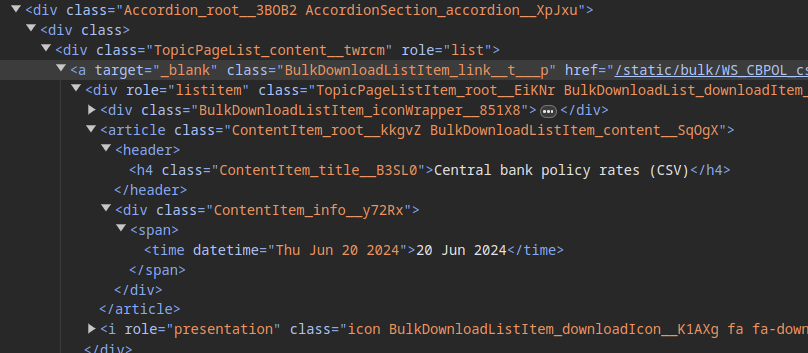

We can see that there are a lot of `<` tags and other information we don't usually see when browsing the web. These tags tell your browser how the things should be shown to you, in what order, what content, which style, etc.

Because we are looking for links, the relevant type of tag is the `<a>` tag.

We can see that it has some info about a `target`, `class`, and `href`.

- `target`: This one can be ignored.
- `class`: This typically determines the style and is very important for us to extract the *relevant* links from the website.
- `href`: This is the actual link that will be opened when you click on it.

Note: This set of information is specific to this specific website! They are very common, but apart from the href, they may or may not be used.

Now let's load our raw website into BeautifulSoup.

In [ ]:
soup = BeautifulSoup(response.content)

We can use the `find_all()` method of the soup object (which contains our website) to search for the type of tag. We want the `a` tag.
We can additionally filter which links we are interested in, because there are a lot of irrelevant links on the website. Thus, we filter by the class of the link.

How do you approach this when doing it yourself? Ask Google / ChatGPT how to get all links with BeautifulSoup that have a specific class.

In [ ]:
links = soup.find_all('a', class_='BulkDownloadListItem_link__t___p')
links[0]

In [ ]:
len(links) - len(soup.find_all('a')) # We dropped some links through our filter with the class.

Now, we can get the actual link (and class / target) from the link object by treating it like a dictionary:

In [ ]:
link = links[0]
link['href'], link['class'], link['target']

Of course, we only care about the actual link, so we can collect all the links into a list:

In [ ]:
[l['href'] for l in links][:5]

We notice that the links seem to be missing something right? There is no `www.bis.org`. This is because these links are relative links. They are relative to the website we found them on.

We found them on `https://data.bis.org/bulkdownload`, which means that they are relative to `https://data.bis.org`.
In order to get usable links, we can prefix this part to our links:

In [ ]:
BASE_URL = "https://data.bis.org"
clean_links = [BASE_URL + l['href'] for l in links]

In [ ]:
clean_links[:2] # We can verify that we have a good link by clicking on it in the browser.

**Quick exercise**

- Get all `a` tags with the class `button`. How many are there?

### Downloading and saving the file

Let's first look at how a single file can be downloaded and processed. So we pick one of the smaller files from the list.

In [ ]:
link = 'https://data.bis.org/static/bulk/WS_CBPOL_csv_col.zip'
link # That should be our WS_CBPOL_csv_col file, which is quite small

**Specifying the output path**

We want to prepare the folder and filename to save the downloaded file to.
We can use `pathlib`'s `Path` for this.

`Path().cwd()` gives you the `c`urrent `w`orking `d`irectory.
Now we see that our URL we want to download also looks like a path. So we can make use of `pathlib`'s ability to easily extract the filename: `Path(f).name`

Then we want to combine both the folder (the current working directory) and the filename. In pathlib, we can *divide* the two to combine them.

In [ ]:
output_folder = Path().cwd() / "BIS"
output_folder.mkdir(exist_ok=True) # This will create the directory if it does not yet exist.
output_folder

In [ ]:
# Get the output file
fname = output_folder / Path(link).name
fname

In [ ]:
# Download the data with headers and check the status code
response = requests.get(link)
response.status_code

One of the advantages of using `pathlib` to specify the target file is that we can easily write data to the file by using the `write_bytes` or `write_text` method. In this case we have a `.zip` file, which is not text and thus should be written as bytes.
We can access the downloaded file contents from `response.content`.

In [ ]:
# Write the data to a file
fname.write_bytes(response.content)

**Quick exercise**

- Turn the code for downloading and saving a single file into a function that takes the link as argument.
- Then run your function on the LAST 2 (!!! ONLY DO TWO !!!) links. `clean_links[-2:]` !!! Show a progress bar. `time.sleep(1)` after each download.

## Scraping modern websites

Most modern websites deliver JSON (like the API) in one way or the other, which typically contains the information we are interested in.

Let's take a look at the [Fortune 100 Best Companies to Work For](https://fortune.com/ranking/best-companies/2024/).

In [24]:
response = requests.get("https://fortune.com/ranking/best-companies/2024")
print(response.status_code)

200


In [25]:
# Read all tables from the downloaded website with pandas and get the first table in the list
pd.read_html(response.content)[0].head(2)

,RemoveRank,RemoveName,Remove% Women,Remove% Minorities,RemoveU.S. job openings,RemoveFully paid maternal leave (days),RemoveFully paid paternal leave (days),RemoveFully paid adoptive leave (days),RemovePaid days off for volunteering,Unnamed: 9
0,1,Hilton Worldwide Holdings,-,-,2460,60,20,20,No,View More details about Hilton Worldwide Holdings
1,2,Cisco,31%,-,1800,151,65,65,Yes,View More details about Cisco


In [13]:


import requests

cookies = {
    '_pctx': '^%^7Bu^%^7DN4IgrgzgpgThIC4B2YA2qA05owMoBcBDfSREQpAeyRCwgEt8oBJAEzIEYOBmAVgCZ^%^2B3ABwB2cQDYB40fwAMIAL5A',
    '_pcid': '^%^7B^%^22browserId^%^22^%^3A^%^22m3ol9j3h97xuby9p^%^22^%^7D',
    '_pn_GvbR9fxg': 'eyJzdWIiOnsidWRyIjowLCJpZCI6IkhtYnRCaUtxZUhkWWh2OW12NXppVWtNNG16UXQ3dmxhIiwic3MiOjB9LCJsdWEiOjE3MzIwMjg4NjIxOTN9',
    '__pid': '.fortune.com',
    '__pat': '-18000000',
    '__pvi': 'eyJpZCI6InYtbTNvbDlqM2szNXh3cGxqNyIsImRvbWFpbiI6Ii5mb3J0dW5lLmNvbSIsInRpbWUiOjE3MzIwMjg4OTI3Njd9',
    '_pcus': 'eyJ1c2VyU2VnbWVudHMiOnsiQ09NUE9TRVIxWCI6eyJzZWdtZW50cyI6WyJMVHM6MDVjNTVjYTVmODM1ZDk0N2YxNjBjYjRkZDJmZTg3ZmFlZDE2N2IyMTpub19zY29yZSIsIkxUYzoxNjZiMTQxMzM1YmFiZTgyYzJkYjFhYTUzNTRiM2U5MDY1MzJmOTg5Om5vX3Njb3JlIiwiQ1Njb3JlOjYxNDczMTdjZmYxM2I0YTU5YzMwZTliYTRkMDE3YzgwZTU0ZDJkYzI6bm9fc2NvcmUiLCJMVHJlZzpkNTc1MTg0ODc1NWZlNjA1MGM5NDliYWNjN2NmMTA2NjRhMDlhNDFhOm5vX3Njb3JlIiwiTFRyZXR1cm46ZTA2YWExMWU2Y2UyY2U3NzEwMWVkODZlNGFiYzA0YWFlM2ZkM2E3ZDpub19zY29yZSJdfX19',
    '_gcl_au': '1.1.600483655.1732028876',
    'OptanonConsent': 'isGpcEnabled=0&datestamp=Tue+Nov+19+2024+16^%^3A08^%^3A15+GMT^%^2B0100+(Central+European+Standard+Time)&version=202409.1.0&browserGpcFlag=0&isIABGlobal=false&identifierType=Cookie+Unique+Id&hosts=&consentId=b882aaf7-7a25-4f43-b672-971bd8f76eec&interactionCount=1&isAnonUser=1&landingPath=NotLandingPage&groups=C0001^%^3A1^%^2CC0003^%^3A0^%^2CC0004^%^3A0^%^2CC0005^%^3A0^%^2CC0002^%^3A0^%^2CBG8^%^3A0^%^2CV2STACK42^%^3A0&iType=2&intType=2',
    '__tbc': '^%^7Bkpex^%^7DC5xRjcsWSXmtbd0ODp4KVtK5rUAFB28fNaWhgIX_ZuVgXV-1yL6pUGiO6fHiK9w0',
    'xbc': '^%^7Bkpex^%^7DkcBkD9I2f4vhod_SR5QlteiibvZLNRQ0tia1AWvhjLsVuxdzRwxrIx48Ko2a2vSZsrqfe2yUj5KSnd7-3XZvPg',
    'OptanonAlertBoxClosed': '2024-11-19T15:08:15.446Z',
    'eupubconsent-v2': 'CQIVcVgQIVcVgAcABBENBPFwAAAAAAAAACiQAAAU1gDAGfAdsBRQCi0FGgUcApqAAAAA.YAAAAAAAAAAA',
    'OTAdditionalConsentString': '1~',
    'cX_P': 'm3ol9j3h97xuby9p',
}

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:132.0) Gecko/20100101 Firefox/132.0',
    'Accept': '*/*',
    'Accept-Language': 'en-US,en;q=0.5',
    # 'Accept-Encoding': 'gzip, deflate, br, zstd',
    'Referer': 'https://fortune.com/ranking/best-companies/2024/',
    'Connection': 'keep-alive',
    # 'Cookie': '_pctx=^%^7Bu^%^7DN4IgrgzgpgThIC4B2YA2qA05owMoBcBDfSREQpAeyRCwgEt8oBJAEzIEYOBmAVgCZ^%^2B3ABwB2cQDYB40fwAMIAL5A; _pcid=^%^7B^%^22browserId^%^22^%^3A^%^22m3ol9j3h97xuby9p^%^22^%^7D; _pn_GvbR9fxg=eyJzdWIiOnsidWRyIjowLCJpZCI6IkhtYnRCaUtxZUhkWWh2OW12NXppVWtNNG16UXQ3dmxhIiwic3MiOjB9LCJsdWEiOjE3MzIwMjg4NjIxOTN9; __pid=.fortune.com; __pat=-18000000; __pvi=eyJpZCI6InYtbTNvbDlqM2szNXh3cGxqNyIsImRvbWFpbiI6Ii5mb3J0dW5lLmNvbSIsInRpbWUiOjE3MzIwMjg4OTI3Njd9; _pcus=eyJ1c2VyU2VnbWVudHMiOnsiQ09NUE9TRVIxWCI6eyJzZWdtZW50cyI6WyJMVHM6MDVjNTVjYTVmODM1ZDk0N2YxNjBjYjRkZDJmZTg3ZmFlZDE2N2IyMTpub19zY29yZSIsIkxUYzoxNjZiMTQxMzM1YmFiZTgyYzJkYjFhYTUzNTRiM2U5MDY1MzJmOTg5Om5vX3Njb3JlIiwiQ1Njb3JlOjYxNDczMTdjZmYxM2I0YTU5YzMwZTliYTRkMDE3YzgwZTU0ZDJkYzI6bm9fc2NvcmUiLCJMVHJlZzpkNTc1MTg0ODc1NWZlNjA1MGM5NDliYWNjN2NmMTA2NjRhMDlhNDFhOm5vX3Njb3JlIiwiTFRyZXR1cm46ZTA2YWExMWU2Y2UyY2U3NzEwMWVkODZlNGFiYzA0YWFlM2ZkM2E3ZDpub19zY29yZSJdfX19; _gcl_au=1.1.600483655.1732028876; OptanonConsent=isGpcEnabled=0&datestamp=Tue+Nov+19+2024+16^%^3A08^%^3A15+GMT^%^2B0100+(Central+European+Standard+Time)&version=202409.1.0&browserGpcFlag=0&isIABGlobal=false&identifierType=Cookie+Unique+Id&hosts=&consentId=b882aaf7-7a25-4f43-b672-971bd8f76eec&interactionCount=1&isAnonUser=1&landingPath=NotLandingPage&groups=C0001^%^3A1^%^2CC0003^%^3A0^%^2CC0004^%^3A0^%^2CC0005^%^3A0^%^2CC0002^%^3A0^%^2CBG8^%^3A0^%^2CV2STACK42^%^3A0&iType=2&intType=2; __tbc=^%^7Bkpex^%^7DC5xRjcsWSXmtbd0ODp4KVtK5rUAFB28fNaWhgIX_ZuVgXV-1yL6pUGiO6fHiK9w0; xbc=^%^7Bkpex^%^7DkcBkD9I2f4vhod_SR5QlteiibvZLNRQ0tia1AWvhjLsVuxdzRwxrIx48Ko2a2vSZsrqfe2yUj5KSnd7-3XZvPg; OptanonAlertBoxClosed=2024-11-19T15:08:15.446Z; eupubconsent-v2=CQIVcVgQIVcVgAcABBENBPFwAAAAAAAAACiQAAAU1gDAGfAdsBRQCi0FGgUcApqAAAAA.YAAAAAAAAAAA; OTAdditionalConsentString=1~; cX_P=m3ol9j3h97xuby9p',
    'Sec-Fetch-Dest': 'empty',
    'Sec-Fetch-Mode': 'cors',
    'Sec-Fetch-Site': 'same-origin',
}

response = requests.get('https://fortune.com/api/getRankingSearchYear/best-companies/2023/', cookies=cookies, headers=headers)



In [14]:
webdata = json.loads(response.text)['items']
webdata

NameError: name 'json' is not defined

Nice, we got the entire table!

Let's use our browser's developer tools to see what's going on when we click on another year.

You can see that we are loading data from an API in JSON format. Can we simply run this API call? Yes.

An easy way is to copy that command as cURL in your browser, then use something like [curlconverter](https://curlconverter.com/) to convert that into `requests` code. AI is not recommended when you are working with more complicated requests, because it might make mistakes.

Let's paste that below.

In [30]:
headers = {
    'accept': '*/*',
    'accept-language': 'en-US,en;q=0.8',
    'cache-control': 'no-cache',
    'pragma': 'no-cache',
    'priority': 'u=1, i',
    'referer': 'https://fortune.com/ranking/best-companies/2024/',
    'sec-ch-ua': '"Chromium";v="130", "Brave";v="130", "Not?A_Brand";v="99"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Linux"',
    'sec-fetch-dest': 'empty',
    'sec-fetch-mode': 'cors',
    'sec-fetch-site': 'same-origin',
    'sec-gpc': '1',
    'user-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/130.0.0.0 Safari/537.36',
}

apiresponse = requests.get('https://fortune.com/api/getRankingSearchYear/best-companies/2022/', headers=headers)

In [31]:
# Let's parse it
json_data_dict = json.loads(apiresponse.text)

In [32]:
relevant_data = json_data_dict['items']
relevant_data

[{'data': {'% Women': '29.8%',
   '% Minorities': '45.5%',
   'HQ state': 'California',
   '100% health coverage': 'no',
   'Telecommuting': 'yes',
   'Job sharing': 'no',
   'Subsidized childcare': 'no',
   'Compressed work weeks': 'yes',
   'College tuition reimbursement': 'no',
   '# New graduates hired': '502',
   'U.S. job openings': '2,898',
   'On-site medical care facility': 'yes',
   'Unlimited sick days': 'no',
   'Fortune 500': 'yes',
   "World's Most Admired Companies": 'yes',
   'Global 500': 'yes',
   'On-site fitness/subsidized gym': 'yes',
   'Student loan debt repayment': 'no',
   'Industry': 'Information Technology'},
  'name': 'Cisco',
  'order': 1,
  'rank': 1,
  'slug': '/company/cisco-systems-inc/'},
 {'data': {'% Women': '',
   '% Minorities': '',
   'HQ state': 'Virgina',
   '100% health coverage': 'no',
   'Telecommuting': 'confidential',
   'Job sharing': 'yes',
   'Subsidized childcare': 'confidential',
   'Compressed work weeks': 'confidential',
   'College 

In [33]:
df = pd.DataFrame(relevant_data)
df.head()

,data,name,order,rank,slug
0,"{'% Women': '29.8%', '% Minorities': '45.5%', ...",Cisco,1,1,/company/cisco-systems-inc/
1,"{'% Women': '', '% Minorities': '', 'HQ state'...",Hilton Worldwide Holdings,2,2,/company/hilton-worldwide-holdings/
2,"{'% Women': '54.4%', '% Minorities': '26.4%', ...",Wegmans Food Markets,3,3,/company/wegmans-food-markets/
3,"{'% Women': '', '% Minorities': '', 'HQ state'...",Salesforce,4,4,/company/salesforce-com/
4,"{'% Women': '18.6%', '% Minorities': '55.2%', ...",Nvidia,5,5,/company/nvidia/


In [38]:
left= df.loc[:,['name','rank', "slug"]]

In [40]:
nested= pd.json_normalize(df["data"])

Now that we have the data, we can export it or analyze it.

**Quick exercise**

- Expand the 'data' column into new columns. Get it from the dataframe, not the original dictionary. Add them to the DataFrame.

In [43]:
left.merge(nested, how="outer", left_index=True, right_index=True)

,name,rank,slug,% Women,% Minorities,HQ state,100% health coverage,Telecommuting,Job sharing,Subsidized childcare,...,# New graduates hired,U.S. job openings,On-site medical care facility,Unlimited sick days,Fortune 500,World's Most Admired Companies,Global 500,On-site fitness/subsidized gym,Student loan debt repayment,Industry
0,Cisco,1,/company/cisco-systems-inc/,29.8%,45.5%,California,no,yes,no,no,...,502,"2,898",yes,no,yes,yes,yes,yes,no,Information Technology
1,Hilton Worldwide Holdings,2,/company/hilton-worldwide-holdings/,,,Virgina,no,confidential,yes,confidential,...,NaN,"4,132",yes,no,no,yes,no,yes,yes,Hospitality
2,Wegmans Food Markets,3,/company/wegmans-food-markets/,54.4%,26.4%,New York,no,yes,no,no,...,NaN,"2,600",no,no,no,no,no,no,no,Retail
3,Salesforce,4,/company/salesforce-com/,,,California,no,yes,no,confidential,...,NaN,"10,000",no,yes,yes,yes,no,yes,yes,Information Technology
4,Nvidia,5,/company/nvidia/,18.6%,55.2%,California,no,yes,no,yes,...,542,"2,165",no,no,yes,yes,no,no,yes,Information Technology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,T-Mobile US,96,/company/t-mobile/,,,Washington,no,confidential,no,confidential,...,NaN,"2,500",yes,no,no,no,no,yes,no,Telecommunications
96,CrowdStrike,97,/company/crowdstrike/,24.2%,23%,Texas,no,yes,no,no,...,55,364,no,yes,no,no,no,no,no,Information Technology
97,CarMax,98,/company/carmax/,27.5%,53.4%,Virgina,no,yes,yes,yes,...,NaN,"2,000",yes,no,yes,no,no,yes,no,Retail
98,Dow,99,/company/dow/,27.6%,25.1%,Michigan,no,yes,yes,no,...,175,178,yes,yes,yes,yes,yes,yes,no,Manufacturing & Production


## In-class case study
1. Download SEC index files for 2 quarters. You can find the main website [here](https://www.sec.gov/Archives/edgar/full-index/). Hint: `pd.read_csv(io.BytesIO(response.content), compression='zip', ...)` allows you to read the zip file directly from the response without saving it to disk.
2. Combine the data
3. Count and plot the number of 10Ks per month

In [ ]:
url = "https://www.sec.gov/Archives/edgar/full-index/2024/QTR3"

In [12]:
import requests

cookies = {
    'ak_bmsc': 'C3616ADDBBB66CA1D01AD3847170CB73~000000000000000000000000000000~YAAQkV5swemUmUmTAQAAhNYJTBl47pha6vh08L/4lCTUC0943gyDkjkvngwnuz0WCKTQWQshZIjwwAWle/hoTMjU9c/TvcAiVpPmhi71I+0plrRGs/8Nhm7OjfXAqQBjelC1g1uROWHzB3AaW96RT0Z0arqIg8d+M/7eifbCcPfflk3Uw4bOCjys3uh9qWDSsfCV89qCi3Qo7XEtRTxHHyKRShpsCVDVVbn1UoPgDWTgZEdejexMnYNX5uNen9UYUzd+hE1hKoqt0mS55wjIdfwLmEzrHFXPV/N/StROceyXbx4bf9A2GiOOQsJKKz2pkVa4AZVl7ZlA0mcyNGhhZx7GRNJ9DpmT0gyryzBCNG/U0fbRTDQCFlNi+hUCGOGI4fsGjnnrpm8reLayEs0o0P5HhdFMrOOLEugxe1sLz/mvyckjtswu1k0qe9hH38S1IpCR2qqtT97z',
    'bm_sv': '78F76E3C8C7D8DEA0892539D53C79075~YAAQdo8UAgyP6kWTAQAArLMdTBnTa8jF66McrOKqu3Xj/eo+DOPXPLnT7AB6p3wY+5saTHl77Efnkm9sYYmRUKhmtCV+fWT793Kty/rtTmyLc5OE3EeJRanpGrPoygbAPk8TM+EG73XaWYrNfCSVReKzURGwhYtrb9WeE3CLA8OSC6g5f4TrbyRQ5blfvn17hsTga4VR0jaueEqfnNvEhhMfwjqL3SYjHIH7pngkG16dqmuXwa1ZHZngsVah~1',
}

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:132.0) Gecko/20100101 Firefox/132.0',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
    'Accept-Language': 'en-US,en;q=0.5',
    # 'Accept-Encoding': 'gzip, deflate, br, zstd',
    'Connection': 'keep-alive',
    'Referer': 'https://www.sec.gov/Archives/edgar/full-index/2024/QTR3/',
    # 'Cookie': 'ak_bmsc=C3616ADDBBB66CA1D01AD3847170CB73~000000000000000000000000000000~YAAQkV5swemUmUmTAQAAhNYJTBl47pha6vh08L/4lCTUC0943gyDkjkvngwnuz0WCKTQWQshZIjwwAWle/hoTMjU9c/TvcAiVpPmhi71I+0plrRGs/8Nhm7OjfXAqQBjelC1g1uROWHzB3AaW96RT0Z0arqIg8d+M/7eifbCcPfflk3Uw4bOCjys3uh9qWDSsfCV89qCi3Qo7XEtRTxHHyKRShpsCVDVVbn1UoPgDWTgZEdejexMnYNX5uNen9UYUzd+hE1hKoqt0mS55wjIdfwLmEzrHFXPV/N/StROceyXbx4bf9A2GiOOQsJKKz2pkVa4AZVl7ZlA0mcyNGhhZx7GRNJ9DpmT0gyryzBCNG/U0fbRTDQCFlNi+hUCGOGI4fsGjnnrpm8reLayEs0o0P5HhdFMrOOLEugxe1sLz/mvyckjtswu1k0qe9hH38S1IpCR2qqtT97z; bm_sv=78F76E3C8C7D8DEA0892539D53C79075~YAAQdo8UAgyP6kWTAQAArLMdTBnTa8jF66McrOKqu3Xj/eo+DOPXPLnT7AB6p3wY+5saTHl77Efnkm9sYYmRUKhmtCV+fWT793Kty/rtTmyLc5OE3EeJRanpGrPoygbAPk8TM+EG73XaWYrNfCSVReKzURGwhYtrb9WeE3CLA8OSC6g5f4TrbyRQ5blfvn17hsTga4VR0jaueEqfnNvEhhMfwjqL3SYjHIH7pngkG16dqmuXwa1ZHZngsVah~1',
    'Upgrade-Insecure-Requests': '1',
    'Sec-Fetch-Dest': 'document',
    'Sec-Fetch-Mode': 'navigate',
    'Sec-Fetch-Site': 'same-origin',
    'Sec-Fetch-User': '?1',
    'Priority': 'u=0, i',
    # Requests doesn't support trailers
    # 'TE': 'trailers',
}

response = requests.get('https://www.sec.gov/Archives/edgar/full-index/2024/QTR3/master.zip', cookies=cookies, headers=headers)

In [58]:
data = pd.read_csv(io.BytesIO(response.content), compression='zip', sep="|", skiprows=11)
data.head(5)

,1000045,NICHOLAS FINANCIAL INC,10-K/A,2024-07-29,edgar/data/1000045/0001193125-24-187727.txt
0,1000045,NICHOLAS FINANCIAL INC,10-K,2024-07-01,edgar/data/1000045/0000950170-24-079650.txt
1,1000045,NICHOLAS FINANCIAL INC,10-Q,2024-08-26,edgar/data/1000045/0000950170-24-100547.txt
2,1000045,NICHOLAS FINANCIAL INC,3,2024-09-18,edgar/data/1000045/0001903601-24-000094.txt
3,1000045,NICHOLAS FINANCIAL INC,4,2024-09-18,edgar/data/1000045/0001903601-24-000095.txt
4,1000045,NICHOLAS FINANCIAL INC,8-K/A,2024-08-29,edgar/data/1000045/0000950170-24-101833.txt


### Developing

This part shows you the typical development stage. We try the things one-by-one before putting everything into an easy-to-use function that is more production-ready.

First, we go to the website in our browser. Then we check what the structure of the URL is like. We can see that when we enter the folders on the website, the folder names are simply appended to the URL.

For example, we can find a `master.zip` file at `https://www.sec.gov/Archives/edgar/full-index/2000/QTR1/master.zip` for the first quarter of year 2000.

So we can write a template for the URL, where we can substitute the year and quarter we are interested in.

Remember that we can use curly braces `{}` to specify the places where we want to substitute. If we put in words, e.g. `{year}`, we can then provide the value through the keyword argument `year` at format time.

Note that the format is almost identical to f-strings, but we do not put the `f` in front, because that would format the string immediately! But we want to format it later with the `.format()` method.

In [ ]:
TEMPLATE_URL = "https://www.sec.gov/Archives/edgar/full-index/{year}/QTR{quarter}/master.zip"

For testing purposes during the development of the code, we simply specify some variables.
Then we can `.format()` the template URL with our variables.

In [ ]:
year = 1999
quarter = 1

url = TEMPLATE_URL.format(year=year, quarter=quarter)
url

Now make the request and verify that we have a `200` status code.

In [ ]:
response = requests.get(url)
print(response.status_code)

Oh no, we got a status code `403`. That means that we are not allowed to access the website.

Why is that? That's because the SEC states that automated scraping has to follow some rules. In the [developer documentation](https://www.sec.gov/os/webmaster-faq#developers), we can see that we need to specify a `User Agent` and provide some information.

The `User Agent` is part of the so called `headers` that are sent with HTTP requests.

If we add the proper headers, our request works (status code `200`).

In [ ]:
# We always need the headers
headers = {
    'User-Agent': 'University of Mannheim myemail@uni-mannheim.de'
}

In [ ]:
response = requests.get(url, headers=headers)
print(response.status_code)

Now we can try to load the data with pandas read_csv. But it looks really bad... We need additional keyword arguments! Let's go through it step by step.

In [ ]:
columns = {
    'cik':int,
    'companyname':str,
    'formtype':str,
    'filingdate':str,
    'filename':str,
}
master_index = pd.read_csv(io.BytesIO(response.content), compression='zip', sep='|', skiprows=11, names=columns.keys(), dtype=columns)
master_index['filingdate'] = pd.to_datetime(master_index['filingdate'])

master_index.sample(3)

Now that we have our data for a single quarter, we can first filter to 10-Ks only, then group it by month, and count them.

In [ ]:
master_index.query("formtype =='10-K'").groupby(pd.Grouper(freq='ME',key='filingdate')).size()
#                                                                   ^ we need the key, because we are not grouping on the index

That seems to work for a single quarter, so now we want to turn that into a function and run it on multiple quarters.

### Production code

Now that we have figured out how to download, parse and aggregate the data, we can turn that into a function that is easier to use.

In [ ]:
def download_sec_index(year, quarter):
  url = TEMPLATE_URL.format(year=year, quarter=quarter)
  response = requests.get(url, headers=headers)
  if response.status_code != 200:
    print(f"Error: {response.status_code}")
    return

  columns = {
    'cik':int,
    'companyname':str,
    'formtype':str,
    'filingdate':str,
    'filename':str,
  }
  master_index = pd.read_csv(io.BytesIO(response.content), compression='zip', sep='|', skiprows=11, names=columns.keys(), dtype=columns)
  master_index['filingdate'] = pd.to_datetime(master_index['filingdate'])
  return master_index

We can write a for loop to iterate over two year-quarter combinations, use our function to download it, collect the cleaned data and then concatenate it to form one large dataset.

In [ ]:
master_index = []

for year, quarter in [(1999, 1), (1999,2)]:
  mi = download_sec_index(year, quarter)
  master_index.append(mi)
  time.sleep(2) # Wait 2 seconds before the next request

master_index = pd.concat(master_index)

Then we can group the data by month and plot it in a bar chart.

In [ ]:
master_index.query("formtype =='10-K'").groupby(pd.Grouper(freq='ME',key='filingdate')).size().plot.bar()

## Exercises

Choose a website you want to obtain data from. It should not require a login. That can be your sports ticker, your recipe website, or a shopping website.

If you have no idea, look at sephora.com

Please keep in mind the following:

Be NICE when scraping!
- Go slow. Do not use loops without delays.
- Download as little as possible. Save your response to a variable immediately and keep programming in the next cell with your SAVED variable contents.
- If you use loops, limit them to very few elements while you are programming.
- Catch errors so you don't need to redownload data that was actually fine.

Tasks:

- Check how the website behaves in the browser's developer tools. Is a modern website?
- Look at the requests that are being made. What other types (apart from `GET`) can you spot?
- Try to convert the interesting requests to python code via cURL to requests converters.
- Try to download the data and turn it into a DataFrame.

In [18]:
import requests

cookies = {
    '_ga_PPY9Z37CCJ': 'GS1.1.1732178164.8.1.1732178230.60.0.0',
    '_ga': 'GA1.1.1105059288.1729088377',
    '_ga_L8WS4GS6YR': 'GS1.1.1732178180.7.1.1732178230.0.0.0',
    '_ga_XXT0Y3PW8P': 'GS1.1.1731748409.2.1.1731748952.0.0.0',
    'PHPSESSID': 'ac0qug4kem8snh6v4mcdj1nao7',
    '__cfruid': '9d0ac4fe230014d13db3db4b39eb1760d4ec0776-1732178163',
    '_cfuvid': '204DnnRMJQMn4MgTnfUV.E9rvsp_ocq3JHVOX6_JRn4-1732178163099-0.0.1.1-604800000',
    '__cf_bm': 'P7Y5lGNZ7jINQqjgt2dOShy81B7H4UUULu7BBpyd4k4-1732178163-1.0.1.1-VjPQVGHrwGiqEDjVJJMjjEfWSxZPVX9Vejr7JfFhyqnoZCpfjr4oqgM6ekwA1XH5oROAdFj4gjObutUAIoZGXA',
    'cf_clearance': 'qCcofpHB39OzqcWxCGCENzq6Yquabjl5jykCMMAM3V8-1732178163-1.2.1.1-ZcZTkkoTKWlLXZBnH8okxWqAXHQVuGh764DlZ0RJlhhnsiqH64.._DkA1N4fTBKcJy083.EFQ8_IltjnaCxCIKs5dReBspx5qJ9qmxNqtbWZiiz6Yl_bcD7GTS6vHBUvrh1vHKX8uSBbtlRke7HMD8bpp7kF3yv.DerWiQLVNyHM3nRNUpJTe0VyVA3IwPK3ohabDZkZzbZxnSt46HGZr3aqbENS9vbNGgERLhAJNv7FGi.vq_7tOGl5AN2zukfpbkiur_Py44OH27ru0cxbOFUtvBv7RLBjjOoWJSlL0g1zNyWJK.cDtRep.SuV0vmNdquqT4DXJ4ZdVZdrkbVPlGSfas9yCmKYGhvq4zIGq9w',
}

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:132.0) Gecko/20100101 Firefox/132.0',
    'Accept': 'application/json, text/plain, */*',
    'Accept-Language': 'en-US,en;q=0.5',
    # 'Accept-Encoding': 'gzip, deflate, br, zstd',
    'X-LI-DEVICE': '535832e686d1d9075bc47fa56f5d2d7acebc2c95',
    'X-LI-DEVICE-TYPE': 'browser',
    'X-LI-LOAD-TIME': '5.2710247',
    'Connection': 'keep-alive',
    'Referer': 'https://lihkg.com/thread/3826211/page/1',
    # 'Cookie': '_ga_PPY9Z37CCJ=GS1.1.1732178164.8.1.1732178230.60.0.0; _ga=GA1.1.1105059288.1729088377; _ga_L8WS4GS6YR=GS1.1.1732178180.7.1.1732178230.0.0.0; _ga_XXT0Y3PW8P=GS1.1.1731748409.2.1.1731748952.0.0.0; PHPSESSID=ac0qug4kem8snh6v4mcdj1nao7; __cfruid=9d0ac4fe230014d13db3db4b39eb1760d4ec0776-1732178163; _cfuvid=204DnnRMJQMn4MgTnfUV.E9rvsp_ocq3JHVOX6_JRn4-1732178163099-0.0.1.1-604800000; __cf_bm=P7Y5lGNZ7jINQqjgt2dOShy81B7H4UUULu7BBpyd4k4-1732178163-1.0.1.1-VjPQVGHrwGiqEDjVJJMjjEfWSxZPVX9Vejr7JfFhyqnoZCpfjr4oqgM6ekwA1XH5oROAdFj4gjObutUAIoZGXA; cf_clearance=qCcofpHB39OzqcWxCGCENzq6Yquabjl5jykCMMAM3V8-1732178163-1.2.1.1-ZcZTkkoTKWlLXZBnH8okxWqAXHQVuGh764DlZ0RJlhhnsiqH64.._DkA1N4fTBKcJy083.EFQ8_IltjnaCxCIKs5dReBspx5qJ9qmxNqtbWZiiz6Yl_bcD7GTS6vHBUvrh1vHKX8uSBbtlRke7HMD8bpp7kF3yv.DerWiQLVNyHM3nRNUpJTe0VyVA3IwPK3ohabDZkZzbZxnSt46HGZr3aqbENS9vbNGgERLhAJNv7FGi.vq_7tOGl5AN2zukfpbkiur_Py44OH27ru0cxbOFUtvBv7RLBjjOoWJSlL0g1zNyWJK.cDtRep.SuV0vmNdquqT4DXJ4ZdVZdrkbVPlGSfas9yCmKYGhvq4zIGq9w',
    'Sec-Fetch-Dest': 'empty',
    'Sec-Fetch-Mode': 'cors',
    'Sec-Fetch-Site': 'same-origin',
    # Requests doesn't support trailers
    # 'TE': 'trailers',
}

params = {
    'order': 'reply_time',
}

response = requests.get('https://lihkg.com/api_v2/thread/3826211/page/1', params=params, cookies=cookies, headers=headers)

In [6]:
import pandas as pd

In [43]:
json.loads(response.text)['response']['item_data'][0]['msg']

'C長 : 47人案算唔算已重判? 需唔需要上訴?'